In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/conll003-englishversion/valid.txt
/kaggle/input/conll003-englishversion/metadata
/kaggle/input/conll003-englishversion/test.txt
/kaggle/input/conll003-englishversion/train.txt


In [2]:
!pip -q install -U spacy==3.7.5 spacy-transformers==1.3.4 seqeval==1.2.2 pandas==2.2.2 matplotlib==3.9.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.2/920.2 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   

In [3]:
import os 
from collections import Counter, defaultdict
import time 
import matplotlib.pyplot as plt
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from spacy import displacy
from seqeval.metrics import classification_report, f1_score

In [4]:
pd.set_option("display.max_rows" , 100)
pd.set_option("display.max_colwidth", 100)

data_dir = "/kaggle/input/conll003-englishversion/"
work_dir = "/kaggle/working" if os.path.isdir("/kaggle/working") else "."

print(data_dir, work_dir)

/kaggle/input/conll003-englishversion/ /kaggle/working


In [5]:
def load_conll(path):
    sents, tags = [], []
    cur_tokens , cur_tags = [], []
    with open(path, encoding ='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if cur_tokens:
                    sents.append(cur_tokens)
                    tags.append(cur_tags)
                    cur_tokens,cur_tags = [],[]
                continue
            if line.startswith("-DOCSTART-"):
                if cur_tokens:
                    sents.append(cur_tokens)
                    tags.append(cur_tags)
                    cur_tokens, cur_tags = [], []
                continue
            parts = line.split()
            tokens = parts[0]
            ner_tag = parts[-1]
            cur_tokens.append(tokens)
            cur_tags.append(ner_tag)
    if cur_tokens:
        sents.append(cur_tokens)
        tags.append(cur_tags)
    return sents, tags

train_sents, train_tags = load_conll(os.path.join(data_dir, "train.txt"))
valid_sents, valid_tags = load_conll(os.path.join(data_dir, "valid.txt"))
test_sents, test_tags = load_conll(os.path.join(data_dir, "test.txt"))

for name, s, t in [("train", train_sents, train_tags),
                   ("valid", valid_sents, valid_tags),
                   ("test",  test_sents,  test_tags)]:
    print(f"{name:>5} | sentences: {len(s):5d} | tokens: {sum(len(x) for x in s):7d}")

train | sentences: 14041 | tokens:  203621
valid | sentences:  3250 | tokens:   51362
 test | sentences:  3453 | tokens:   46435


In [6]:
def show_sentence(idx, sents, tags):
    tokens = sents[idx]
    ner = tags[idx]
    df = pd.DataFrame({'token':tokens, "tag":ner})
    return df

display(show_sentence(0,train_sents, train_tags))
display(show_sentence(1,train_sents, train_tags))

,token,tag
0,EU,B-ORG
1,rejects,O
2,German,B-MISC
3,call,O
4,to,O
5,boycott,O
6,British,B-MISC
7,lamb,O
8,.,O


,token,tag
0,Peter,B-PER
1,Blackburn,I-PER


Entity counts (train, base types): Counter({'PER': 11128, 'ORG': 10025, 'LOC': 8297, 'MISC': 4593})


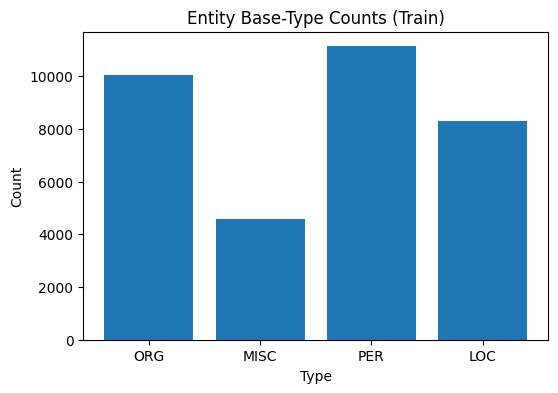

In [7]:

def base_tag(tag):
    return tag.split("-")[-1] if tag != "O" else "O"

flat_train_tags = [t for seq in train_tags for t in seq]
entity_bases = [base_tag(t) for t in flat_train_tags if t != "O"]
counts = Counter(entity_bases)

print("Entity counts (train, base types):", counts)

plt.figure(figsize=(6,4))
plt.bar(list(counts.keys()), list(counts.values()))
plt.title("Entity Base-Type Counts (Train)")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()


In [8]:
!pip install -U spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstall

In [9]:

nlp_rb = spacy.load("en_core_web_sm")  
matcher = Matcher(nlp_rb.vocab)

pattern_person = [{"POS": "PROPN"}, {"POS": "PROPN"}]
matcher.add("RB_PERSON", [pattern_person])

ORG_KEYWORDS = {"Inc.", "Corp.", "Corporation", "Ltd.", "University", "College", "Bank", "FC", "Club"}

def apply_rule_based(doc):
    matches = matcher(doc)
    spans = []
    for match_id, start, end in matches:
        label = nlp_rb.vocab.strings[match_id]
        spans.append(Span(doc, start, end, label=label))
    
    all_spans = list(doc.ents) + spans
    all_spans = spacy.util.filter_spans(all_spans)
    doc.ents = all_spans
    return doc

sample_text = "Barack Obama gave a talk at Stanford University and later visited Deutsche Bank in Berlin."
doc_rb = nlp_rb(sample_text)
doc_rb = apply_rule_based(doc_rb)

print([(ent.text, ent.label_) for ent in doc_rb.ents])
displacy.render(doc_rb, style="ent", jupyter=True)


/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  if lower_version is not None:
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


[('Barack Obama', 'PERSON'), ('Stanford University', 'ORG'), ('Deutsche Bank', 'ORG'), ('Berlin', 'GPE')]


In [10]:

nlp_sm = spacy.load("en_core_web_sm")
try:
    nlp_trf = spacy.load("en_core_web_trf")
except Exception as e:
    print("Could not load en_core_web_trf. Make sure it's downloaded. Falling back to small model only.")
    nlp_trf = None

demo_text = "Apple is looking at buying a U.K. startup for $1 billion. Barack Obama visited Paris and the United Nations."
doc_sm = nlp_sm(demo_text)
print("SM ents:", [(e.text, e.label_) for e in doc_sm.ents])

if nlp_trf:
    doc_trf = nlp_trf(demo_text)
    print("TRF ents:", [(e.text, e.label_) for e in doc_trf.ents])

displacy.render(doc_sm, style="ent", jupyter=True)
if nlp_trf:
    displacy.render(doc_trf, style="ent", jupyter=True)


Could not load en_core_web_trf. Make sure it's downloaded. Falling back to small model only.
SM ents: [('Apple', 'ORG'), ('U.K.', 'GPE'), ('$1 billion', 'MONEY'), ('Barack Obama', 'PERSON'), ('Paris', 'GPE'), ('the United Nations', 'ORG')]


In [11]:

def spacy_to_conll_label(label):
    if label == "PERSON":
        return "PER"
    if label in ("GPE", "LOC"):
        return "LOC"
    if label == "ORG":
        return "ORG"
    return "MISC"

def token_char_offsets(tokens):
    """Return [(start, end), ...] char offsets if we join tokens with single spaces."""
    offs = []
    pos = 0
    for tok in tokens:
        start = pos
        end = pos + len(tok)
        offs.append((start, end))
        pos = end + 1  # account for the space we will insert
    return offs

def iob_from_doc_for_tokens(tokens, doc):
    """Create BIO tags for our token list based on spaCy doc.ents spans."""
    iob = ["O"] * len(tokens)
    offs = token_char_offsets(tokens)
    for ent in doc.ents:
        label = spacy_to_conll_label(ent.label_)
        s, e = ent.start_char, ent.end_char
        covered = [i for i, (ts, te) in enumerate(offs) if not (te <= s or ts >= e)]
        if covered:
            iob[covered[0]] = f"B-{label}"
            for i in covered[1:]:
                iob[i] = f"I-{label}"
    return iob

def predict_sequences(sents, nlp, limit=None):
    """Predict BIO tag sequences for a list of tokenized sentences using a spaCy nlp."""
    y_pred = []
    N = len(sents) if limit is None else min(limit, len(sents))
    for tokens in sents[:N]:
        text = " ".join(tokens)
        doc = nlp(text)
        y_pred.append(iob_from_doc_for_tokens(tokens, doc))
    return y_pred


In [12]:

EVAL_N_SM = 2000 
print(f"Evaluating en_core_web_sm on first {EVAL_N_SM} test sentences...")

t0 = time.time()
y_true_sm = test_tags[:EVAL_N_SM]
y_pred_sm = predict_sequences(test_sents, nlp_sm, limit=EVAL_N_SM)
t1 = time.time()

f1_sm = f1_score(y_true_sm, y_pred_sm)
tok_count = sum(len(x) for x in test_sents[:EVAL_N_SM])
speed_sm = tok_count / (t1 - t0)

print(f"F1 (micro): {f1_sm:.4f}")
print(f"Speed: {speed_sm:.1f} tokens/sec")
print()
print(classification_report(y_true_sm, y_pred_sm))


Evaluating en_core_web_sm on first 2000 test sentences...
F1 (micro): 0.4552
Speed: 1651.5 tokens/sec

              precision    recall  f1-score   support

         LOC       0.77      0.70      0.73      1021
        MISC       0.10      0.60      0.18       433
         ORG       0.45      0.39      0.42       901
         PER       0.74      0.58      0.65       975

   micro avg       0.38      0.57      0.46      3330
   macro avg       0.52      0.57      0.49      3330
weighted avg       0.59      0.57      0.55      3330



In [13]:

if nlp_trf:
    EVAL_N_TRF = 1000  # reduce/increase based on runtime
    print(f"Evaluating en_core_web_trf on first {EVAL_N_TRF} test sentences...")

    t0 = time.time()
    y_true_trf = test_tags[:EVAL_N_TRF]
    y_pred_trf = predict_sequences(test_sents, nlp_trf, limit=EVAL_N_TRF)
    t1 = time.time()

    f1_trf = f1_score(y_true_trf, y_pred_trf)
    tok_count = sum(len(x) for x in test_sents[:EVAL_N_TRF])
    speed_trf = tok_count / (t1 - t0)

    print(f"F1 (micro): {f1_trf:.4f}")
    print(f"Speed: {speed_trf:.1f} tokens/sec")
    print()
    print(classification_report(y_true_trf, y_pred_trf))
else:
    f1_trf = None
    speed_trf = None


In [14]:

rows = [{"Model": "en_core_web_sm", "F1": f1_sm, "Speed(tokens/s)": speed_sm}]
if nlp_trf and (f1_trf is not None):
    rows.append({"Model": "en_core_web_trf", "F1": f1_trf, "Speed(tokens/s)": speed_trf})
cmp_df = pd.DataFrame(rows)
cmp_df


,Model,F1,Speed(tokens/s)
0,en_core_web_sm,0.455245,1651.492482


In [15]:

EXPORT_N = 200  

y_true = test_tags[:EXPORT_N]
if 'y_pred_sm' not in globals() or len(y_pred_sm) < EXPORT_N:
    y_pred_sm = predict_sequences(test_sents, nlp_sm, limit=EXPORT_N)

if nlp_trf:
    y_pred_trf = predict_sequences(test_sents, nlp_trf, limit=EXPORT_N)
else:
    y_pred_trf = [None] * EXPORT_N

rows = []
for s_idx in range(EXPORT_N):
    tokens = test_sents[s_idx]
    for t_idx, tok in enumerate(tokens):
        row = {
            "sent_id": s_idx,
            "token_id": t_idx,
            "token": tok,
            "true": y_true[s_idx][t_idx],
            "sm_pred": y_pred_sm[s_idx][t_idx],
        }
        if nlp_trf and y_pred_trf[s_idx] is not None:
            row["trf_pred"] = y_pred_trf[s_idx][t_idx]
        rows.append(row)

pred_df = pd.DataFrame(rows)
csv_path = os.path.join(work_dir, "ner_predictions_side_by_side.csv")
pred_df.to_csv(csv_path, index=False)
csv_path


'/kaggle/working/ner_predictions_side_by_side.csv'

In [16]:

import random
random.seed(13)

def visualize_sentence(sent_tokens, nlp, title=""):
    text = " ".join(sent_tokens)
    doc = nlp(text)
    print(title or nlp.meta.get("name", "model"))
    displacy.render(doc, style="ent", jupyter=True)

for _ in range(2):
    idx = random.randint(0, len(test_sents)-1)
    toks = test_sents[idx]
    visualize_sentence(toks, nlp_sm, title="en_core_web_sm")
    if nlp_trf:
        visualize_sentence(toks, nlp_trf, title="en_core_web_trf")


en_core_web_sm


en_core_web_sm
